In [1]:
from PIL import Image, ImageEnhance


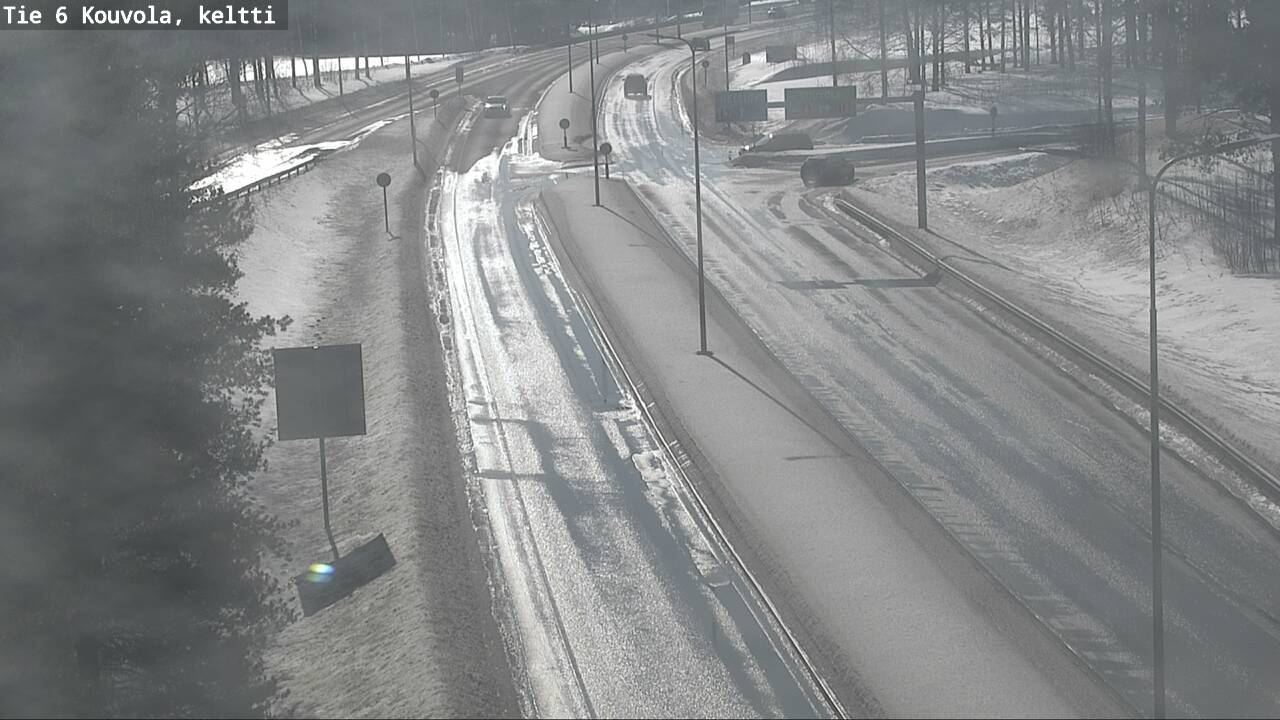

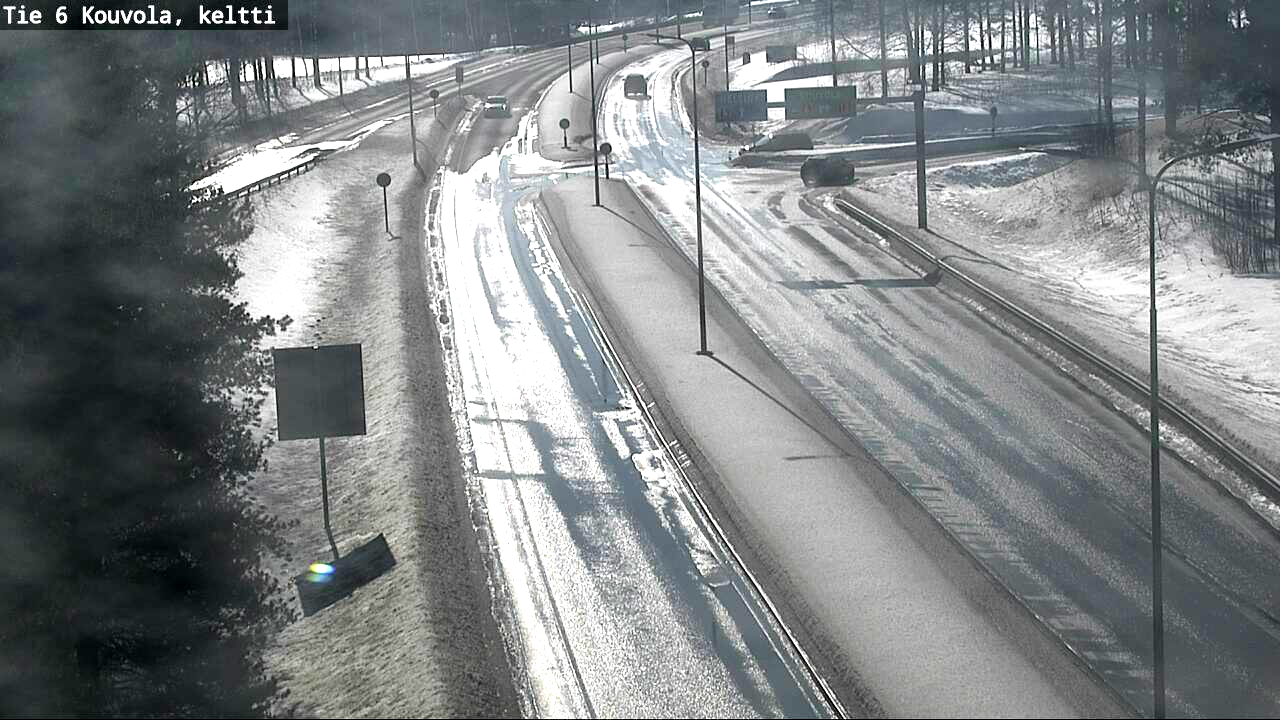

In [8]:
#read the image
im = Image.open("./finland1/FI_20220315110502_C0350602.jpg")
display(im)

#image brightness enhancer
enhancer = ImageEnhance.Contrast(im)

factor = 2 #increase contrast
im_output = enhancer.enhance(factor)
#im_output.save('more-contrast-image.png')
#im_output.show()
display(im_output)

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.metrics import categorical_crossentropy
from sklearn.metrics import confusion_matrix
import itertools
import shutil
import glob
import random
import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile

2022-03-19 12:01:22.602982: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-19 12:01:22.603022: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [11]:
# **Paths:**

pth_validation = "./finland1/validation"
pth_train = "./finland1/train"


path, dirs, files = next(os.walk(pth_train))
#print(len(files))
print(dirs)

['water', 'heavy_snow', 'clean']


In [25]:
from keras.preprocessing.image import ImageDataGenerator

train_btch = ImageDataGenerator(preprocessing_function= tf.keras.applications.vgg16.preprocess_input) \
.flow_from_directory(directory=pth_train, target_size=(224,224), classes = ["water","heavy_snow","clean"], batch_size=2)

validation_btch = ImageDataGenerator(preprocessing_function= tf.keras.applications.vgg16.preprocess_input) \
.flow_from_directory(directory=pth_validation, target_size=(224,224), classes = ["water","heavy_snow","clean"], batch_size=2)

Found 19 images belonging to 3 classes.
Found 11 images belonging to 3 classes.


In [13]:
vgg16_model = tf.keras.applications.vgg16.VGG16()
vgg16_model.summary()

2022-03-19 12:05:39.065262: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-19 12:05:39.065296: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-19 12:05:39.065320: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (yuqi-Yoga-Slim-7-14ARE05): /proc/driver/nvidia/version does not exist
2022-03-19 12:05:39.065720: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-19 12:05:39.235513: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 41

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [19]:
from keras.models import Model

model = Sequential()

for layer in vgg16_model.layers[:-1]:
    model.add(layer)
    
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [20]:
for layer in model.layers:
    layer.trainable = False
model.add(Dense(3, activation="softmax"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [21]:
from tensorflow.keras import optimizers
model.compile(loss="categorical_crossentropy",optimizer=optimizers.RMSprop(lr=1e-3),
              metrics=["accuracy"])

In [26]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
hist = model.fit(
    train_btch,
    epochs=20,
    validation_data=validation_btch,
    callbacks=callbacks,
    verbose=2)

Epoch 1/20
10/10 - 4s - loss: 1.2505 - accuracy: 0.7895 - val_loss: 1.1685 - val_accuracy: 0.8182
Epoch 2/20
10/10 - 4s - loss: 0.8624 - accuracy: 0.8947 - val_loss: 0.7846 - val_accuracy: 0.8182
Epoch 3/20
10/10 - 4s - loss: 0.3525 - accuracy: 0.9474 - val_loss: 0.0873 - val_accuracy: 0.9091
Epoch 4/20
10/10 - 4s - loss: 0.0636 - accuracy: 0.9474 - val_loss: 0.1405 - val_accuracy: 0.9091
Epoch 5/20
10/10 - 3s - loss: 0.1303 - accuracy: 0.9474 - val_loss: 0.0397 - val_accuracy: 1.0000
Epoch 6/20
10/10 - 3s - loss: 0.0111 - accuracy: 1.0000 - val_loss: 0.0054 - val_accuracy: 1.0000
Epoch 7/20
10/10 - 3s - loss: 8.4821e-04 - accuracy: 1.0000 - val_loss: 0.0045 - val_accuracy: 1.0000
Epoch 8/20
10/10 - 3s - loss: 7.0915e-04 - accuracy: 1.0000 - val_loss: 0.0034 - val_accuracy: 1.0000
Epoch 9/20
10/10 - 3s - loss: 6.3979e-04 - accuracy: 1.0000 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 10/20
10/10 - 3s - loss: 5.1768e-04 - accuracy: 1.0000 - val_loss: 0.0038 - val_accuracy: 1.0000
Epo